In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from numba import jit, prange, njit
from blimpy import Waterfall
import time
import random
import datetime
from synthetic_real_dynamic_edit import create_true, create_full_cadence, create_false, create_true_single_shot, create_true_faster
from scipy import spatial
from numpy import dot
from numpy.linalg import norm
import math
from sklearn.metrics import silhouette_score
import sys
sys.path.insert(1, '../ML_Training')
sys.path.insert(2, '../GBT_pipeline')
sys.path.insert(3, '../test_bench')
from preprocess_dynamic import get_data
from single_search import search_model_eval, combine
from skimage.transform import rescale, resize, downscale_local_mean
import gc
from keras.regularizers import l1, l2
from data_generation import create_data_set

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10000)])
        tf.config.experimental.set_virtual_device_configuration(
            gpus[1],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10000)])
        tf.config.experimental.set_virtual_device_configuration(
            gpus[2],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)])
        tf.config.experimental.set_virtual_device_configuration(
            gpus[3],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

/home/pma/.local/lib/python3.6/site-packages/numba/core/decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/home/pma/.local/lib/python3.6/site-packages/numba/core/decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


4 Physical GPUs, 4 Logical GPUs


In [2]:
plate1 = np.load('../../../../../../../datax/scratch/pma/real_filtered_LARGE_HIP110750.npy')[0:5000]
plate2 = np.load('../../../../../../../datax/scratch/pma/real_filtered_LARGE_HIP13402.npy')[8000:10000]
plate3 = np.load('../../../../../../../datax/scratch/pma/real_filtered_LARGE_HIP8497.npy')[20000:]
plate = np.vstack([plate1, plate2, plate3])
del plate1, plate2, plate3
gc.collect()
print(plate.shape)

# plate1 = np.load('../../../../../../../datax/scratch/pma/real_filtered_LARGE_HIP110750.npy')[8000:]
# plate = np.vstack([plate1])
# del plate1
# gc.collect()
# print(plate.shape)

(7000, 6, 16, 4096)


In [3]:
%matplotlib inline
NUM_SAMPLES = 10
data, false_data, true_data = create_data_set(plate, NUM_SAMPLES=NUM_SAMPLES, snr_base=20, snr_range = 10, factor=1)

Creating True
(10, 6, 16, 4096)
(10, 6, 16, 4096) (10, 6, 16, 512)
(10, 6, 16, 512)
(60, 16, 512, 1)
Creating False
(60, 6, 16, 4096) (60, 6, 16, 512)
(60, 6, 16, 512)
Creating True
(30, 6, 16, 4096) (30, 6, 16, 512)
(30, 6, 16, 512)
(30, 6, 16, 4096) (30, 6, 16, 512)
(30, 6, 16, 512)
(60, 6, 16, 512, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  """


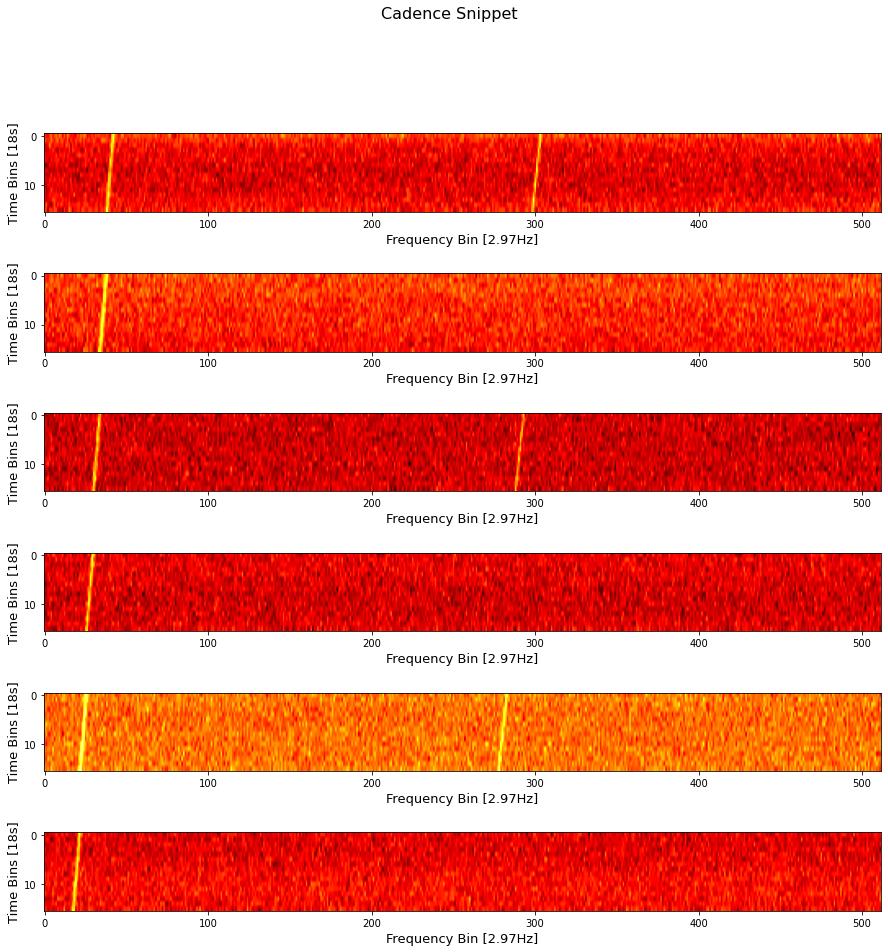

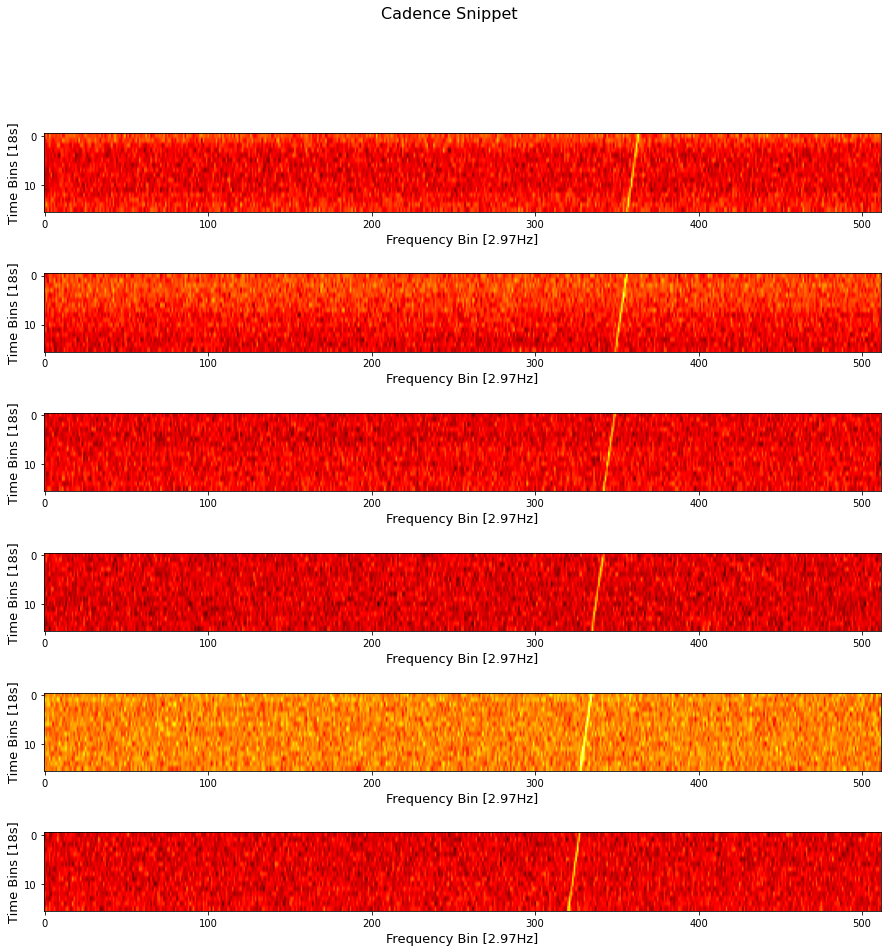

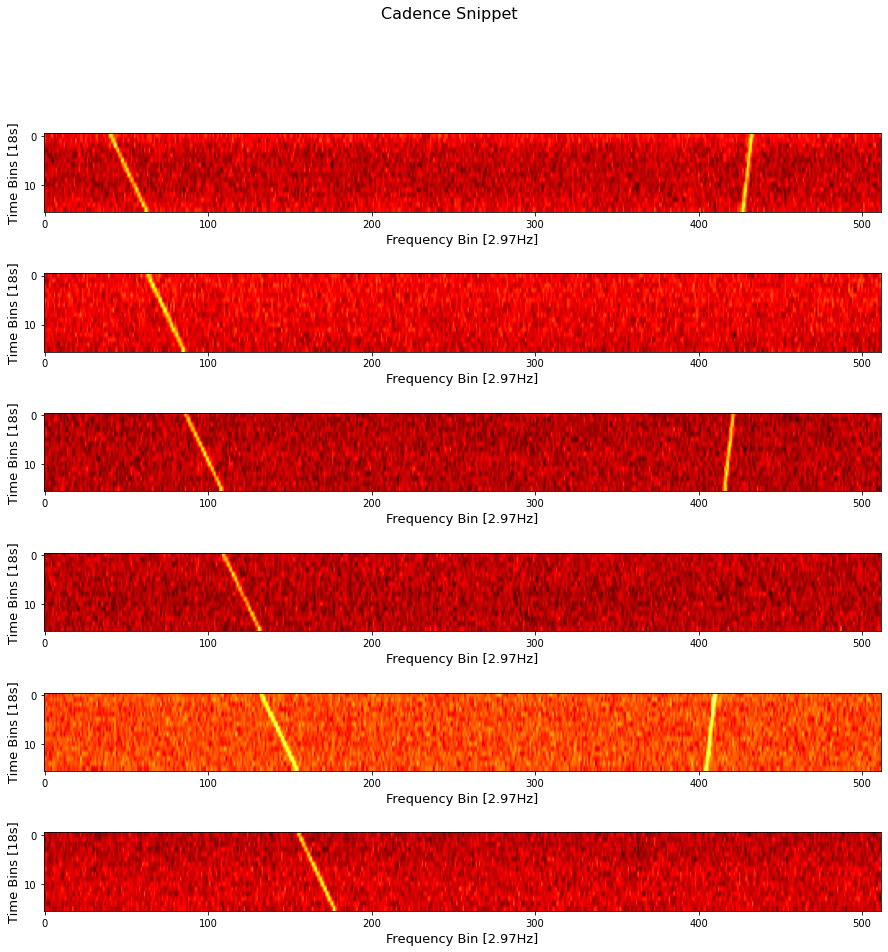

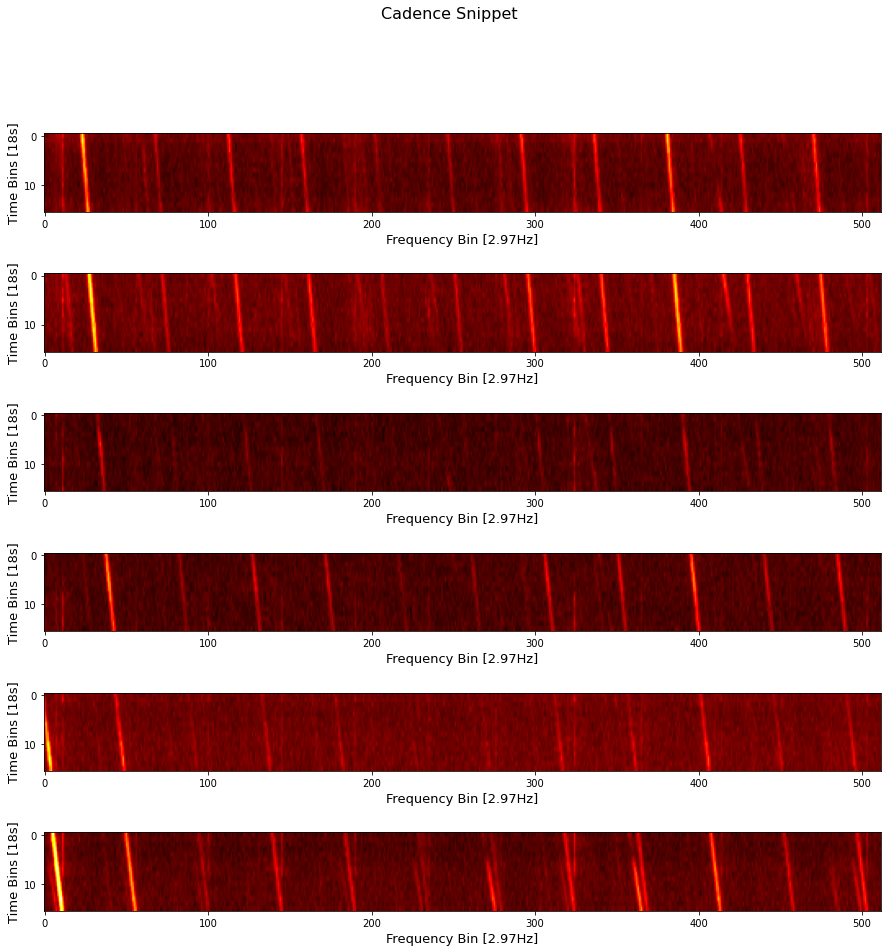

In [4]:
def plot_cadence(data):
    fig, ax = plt.subplots(6, 1, figsize=(15,15))
    fig.suptitle('Cadence Snippet', fontsize=16)
    for i in range(6):
        ax[i].imshow(data[i,:,:], CMAP='hot',aspect=3, vmin = data.min(), vmax = data.max())
        ax[i].set_ylabel('Time Bins [18s]', fontsize=13)
        ax[i].set_xlabel('Frequency Bin [2.97Hz]', fontsize=13)
    plt.show()

plot_cadence(true_data[1,:,:,:])
plot_cadence(false_data[1,:,:,:])
plot_cadence(true_data[0,:,:,:])
plot_cadence(false_data[0,:,:,:])

In [5]:
NUM_SAMPLES = 2
data_test, false_data_test, true_data_test = create_data_set(plate, NUM_SAMPLES=NUM_SAMPLES, snr_base=20, snr_range = 10, factor=1)

Creating True
(2, 6, 16, 4096)
(2, 6, 16, 4096) (2, 6, 16, 512)
(2, 6, 16, 512)
(12, 16, 512, 1)
Creating False
(12, 6, 16, 4096) (12, 6, 16, 512)
(12, 6, 16, 512)
Creating True
(6, 6, 16, 4096) (6, 6, 16, 512)
(6, 6, 16, 512)
(6, 6, 16, 4096) (6, 6, 16, 512)
(6, 6, 16, 512)
(12, 6, 16, 512, 1)


In [6]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder,alpha=10, beta=2, gamma = 10, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.true_loss_tracker = keras.metrics.Mean(name="true_loss")
        self.false_loss_tracker = keras.metrics.Mean(name="false_loss")
        
        self.true_score_tracker = keras.metrics.Mean(name="true_score")
        self.false_score_tracker = keras.metrics.Mean(name="false_score")
        
        
        self.total_loss_tracker_validation = keras.metrics.Mean(name="val_total_loss")
        self.reconstruction_loss_tracker_validation = keras.metrics.Mean(
            name="val_reconstruction_loss"
        )
        self.kl_loss_tracker_validation = keras.metrics.Mean(name="val_kl_loss")
        self.false_loss_tracker_validation = keras.metrics.Mean(name="val_false_loss")
        self.true_loss_tracker_validation = keras.metrics.Mean(name="val_true_loss")
        
        self.true_score_tracker_validation = keras.metrics.Mean(name="true_score")
        self.false_score_tracker_validation = keras.metrics.Mean(name="false_score")
        
        
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.count=1

#     @tf.function
#     def loss_diff(self, a,b):
#         return 1/ self.loss_same(a,b)
    @tf.function
    def loss_diff(self, a,b):
        return tf.math.reduce_mean(1/(tf.math.reduce_euclidean_norm(a-b, axis=1)**2))
    
    @tf.function
    def loss_same(self, a,b):
        return tf.math.reduce_mean(tf.math.reduce_euclidean_norm(a-b, axis=1)**2)

    
    @tf.function
    def true_score(self, true_data,training=True):
        similarity = 0
        difference = 0
        same = 0
        a1 = self.encoder(true_data[:,0,:,:,:], training)[2]
        b = self.encoder(true_data[:,1,:,:,:], training)[2]
        a2 = self.encoder(true_data[:,2,:,:,:],training)[2]
        c = self.encoder(true_data[:,3,:,:,:], training)[2]
        a3 = self.encoder(true_data[:,4,:,:,:], training)[2]
        d = self.encoder(true_data[:,5,:,:,:], training)[2]

        same+= self.loss_same(a1,a2)
        same+= self.loss_same(a1,a3)
        
        same+= self.loss_same(a2,a1)
        same+= self.loss_same(a2,a3)
        
        same+= self.loss_same(a3,a2)
        same+= self.loss_same(a3,a1)
        
        same+= self.loss_same(b,c)
        same+= self.loss_same(b,d)
        
        same+= self.loss_same(c,b)
        same+= self.loss_same(c,d)
        
        same+= self.loss_same(d,b)
        same+= self.loss_same(d,c)
        
        difference += self.loss_same(a1,b)
        difference += self.loss_same(a1,c)
        difference += self.loss_same(a1,d)
        
        difference += self.loss_same(a2,b)
        difference += self.loss_same(a2,c)
        difference += self.loss_same(a2,d)
        
        difference += self.loss_same(a3,b)
        difference += self.loss_same(a3,c)
        difference += self.loss_same(a3,d)
        
        if same > difference:
            similarity += (difference - same)/same
        else:
            similarity += (difference - same)/difference
 
        return 10*(1-similarity)/(2*(similarity+1))
    
    @tf.function
    def false_score(self, true_data,training=True):
        similarity = 0
        difference = 0
        same = 0
        a1 = self.encoder(true_data[:,0,:,:,:], training)[2]
        b = self.encoder(true_data[:,1,:,:,:], training)[2]
        a2 = self.encoder(true_data[:,2,:,:,:],training)[2]
        c = self.encoder(true_data[:,3,:,:,:], training)[2]
        a3 = self.encoder(true_data[:,4,:,:,:], training)[2]
        d = self.encoder(true_data[:,5,:,:,:], training)[2]

        same+= self.loss_same(a1,a2)
        same+= self.loss_same(a1,a3)
        
        same+= self.loss_same(a2,a1)
        same+= self.loss_same(a2,a3)
        
        same+= self.loss_same(a3,a2)
        same+= self.loss_same(a3,a1)
        
        same+= self.loss_same(b,c)
        same+= self.loss_same(b,d)
        
        same+= self.loss_same(c,b)
        same+= self.loss_same(c,d)
        
        same+= self.loss_same(d,b)
        same+= self.loss_same(d,c)
        
        difference += self.loss_same(a1,b)
        difference += self.loss_same(a1,c)
        difference += self.loss_same(a1,d)
        
        difference += self.loss_same(a2,b)
        difference += self.loss_same(a2,c)
        difference += self.loss_same(a2,d)
        
        difference += self.loss_same(a3,b)
        difference += self.loss_same(a3,c)
        difference += self.loss_same(a3,d)
        
        if same > difference:
            similarity += -(difference - same)/same
        else:
            similarity += -(difference - same)/difference
        
        return 10*(1-similarity)/(2*(similarity+1))
    
    @tf.function
    def true_clustering(self, true_data,training=True):
        similarity = 0
        difference = 0
        same = 0
        a1 = self.encoder(true_data[:,0,:,:,:], training)[2]
        b = self.encoder(true_data[:,1,:,:,:], training)[2]
        a2 = self.encoder(true_data[:,2,:,:,:],training)[2]
        c = self.encoder(true_data[:,3,:,:,:], training)[2]
        a3 = self.encoder(true_data[:,4,:,:,:], training)[2]
        d = self.encoder(true_data[:,5,:,:,:], training)[2]

        difference += self.loss_diff(a1,b)
        difference += self.loss_diff(a1,c)
        difference += self.loss_diff(a1,d)

        difference += self.loss_diff(a2,b)
        difference += self.loss_diff(a2,c)
        difference += self.loss_diff(a2,d)

        difference += self.loss_diff(a3,b)
        difference += self.loss_diff(a3,c)
        difference += self.loss_diff(a3,d)

        same += self.loss_same(a1,a2)
        same += self.loss_same(a1,a3)
        same += self.loss_same(a2,a3)
        
        same += self.loss_same(b,c)
        same += self.loss_same(c,d)
        same += self.loss_same(b,d)
        

        similarity += same+difference
        return similarity
    
    @tf.function
    def false_clustering(self, false_data, training=True):

        similarity = 0
        difference = 0
        same = 0
        a1 = self.encoder(false_data[:,0,:,:,:], training)[2]
        b = self.encoder(false_data[:,1,:,:,:], training)[2]
        a2 = self.encoder(false_data[:,2,:,:,:],training)[2]
        c = self.encoder(false_data[:,3,:,:,:], training)[2]
        a3 = self.encoder(false_data[:,4,:,:,:], training)[2]
        d = self.encoder(false_data[:,5,:,:,:], training)[2]

        difference += self.loss_same(a1,b)
        difference += self.loss_same(a1,c)
        difference += self.loss_same(a1,d)

        difference += self.loss_same(a2,b)
        difference += self.loss_same(a2,c)
        difference += self.loss_same(a2,d)

        difference += self.loss_same(a3,b)
        difference += self.loss_same(a3,c)
        difference += self.loss_same(a3,d)

        same += self.loss_same(a1,a2)
        same += self.loss_same(a1,a3)
        same += self.loss_same(a2,a3)
        
        same += self.loss_same(b,c)
        same += self.loss_same(c,d)
        same += self.loss_same(b,d)
        
        similarity += same+difference
        return similarity
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def train_step(self, data):
        self.count+=1
        cluster_loss =0
        x, y = data
        true_data = x[1]
        false_data = x[2]
        x= x[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(y, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            false_loss = self.false_clustering(false_data)
            true_loss = self.true_clustering(true_data)
            
#             false_score = self.false_score(false_data)
#             true_score = self.true_score(true_data)
            false_score =0
            true_score = 0
            
            total_loss = reconstruction_loss + self.beta*kl_loss +self.alpha*(1*true_loss+false_loss)+self.gamma*(false_score+true_score)
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.false_loss_tracker.update_state(false_loss)
        self.true_loss_tracker.update_state(true_loss)
        
        self.false_score_tracker.update_state(false_score)
        self.true_score_tracker.update_state(true_score)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "false_loss": self.false_loss_tracker.result(),
            "true_loss": self.true_loss_tracker.result(),
            "false_score": self.false_score_tracker.result(),
            "true_score": self.true_score_tracker.result()
        }
    

    def test_step(self, data):
        # Unpack the data
        x, y = data
        true_data = x[1]
        false_data = x[2]
        x= x[0]
        z_mean, z_log_var, z = self.encoder(x, training=False)
        reconstruction = self.decoder(z, training=False)
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.binary_crossentropy(y, reconstruction), axis=(1, 2)
            )
        )
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        false_loss = self.false_clustering(false_data, False)
        true_loss = self.true_clustering(true_data, False)
#         false_score = self.false_score(false_data)
#         true_score = self.true_score(true_data)
        false_score = 0
        true_score =0
        total_loss = reconstruction_loss + self.beta*kl_loss +self.alpha*(1*true_loss+false_loss)+self.gamma*(false_score+true_score)
        
        
        self.total_loss_tracker_validation.update_state(total_loss)
        self.reconstruction_loss_tracker_validation.update_state(reconstruction_loss)
        self.kl_loss_tracker_validation.update_state(kl_loss)
        self.false_loss_tracker_validation.update_state(false_loss)
        self.true_loss_tracker_validation.update_state(true_loss)
        
        self.false_score_tracker_validation.update_state(false_score)
        self.true_score_tracker_validation.update_state(true_score)
        
        return {
            "loss": self.total_loss_tracker_validation.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker_validation.result(),
            "kl_loss": self.kl_loss_tracker_validation.result(),
            "false_loss": self.false_loss_tracker_validation.result(),
            "true_loss": self.true_loss_tracker_validation.result(),
            "false_score": self.false_score_tracker_validation.result(),
            "true_score": self.true_score_tracker_validation.result()
        }

In [7]:
from tensorflow.python.client import device_lib
gpus = tf.config.experimental.list_physical_devices('GPU')

In [8]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [9]:
def sample_creation(inputs):
    z_mean = inputs[0]
    z_log_var = inputs[1]
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [10]:
def build_model(latent_dim=8,dens_lay=512, kernel=(3,3), alpha=10, beta=2, gamma=10):
    
    encoder_inputs = keras.Input(shape=(16, 512, 1))
    x = layers.Conv2D(16, kernel, activation="relu", strides=2, padding="same", activity_regularizer=l1(0.001),
                     kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(encoder_inputs)
    x = layers.Conv2D(16, kernel, activation="relu", strides=1, padding="same", activity_regularizer=l1(0.001),
                     kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
    x = layers.Conv2D(32, kernel, activation="relu", strides=2, padding="same", activity_regularizer=l1(0.001),
                     kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
    x = layers.Conv2D(32, kernel, activation="relu", strides=1, padding="same", activity_regularizer=l1(0.001),
                     kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
    x = layers.Conv2D(32, kernel, activation="relu", strides=1, padding="same", activity_regularizer=l1(0.001),
                     kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
    x = layers.Conv2D(64, kernel, activation="relu", strides=2,padding="same", activity_regularizer=l1(0.001),
                     kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
    x = layers.Conv2D(64, kernel, activation="relu", strides=1, padding="same", activity_regularizer=l1(0.001),
                     kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
    x = layers.Conv2D(128, kernel, activation="relu", strides=1, padding="same", activity_regularizer=l1(0.001),
                     kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
    x = layers.Conv2D(256, kernel, activation="relu", strides=2, padding="same", activity_regularizer=l1(0.001),
                     kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
    x = layers.Flatten()(x)
#     x = layers.Dropout(0.5, activity_regularizer=l1(0.001))(x)
    x = layers.Dense(dens_lay, activation="relu", activity_regularizer=l1(0.001),
                     kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
#     x = layers.Dropout(0.5, activity_regularizer=l1(0.001))(x)
    z_mean = layers.Dense(latent_dim, name="z_mean", activity_regularizer=l1(0.001),
                          kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var" , activity_regularizer=l1(0.001),
                             kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    encoder.summary()
    
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(dens_lay, activation="relu", activity_regularizer=l1(0.001), 
                     kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(latent_inputs)
#     x = layers.Dropout(0.5)(x)
    x = layers.Dense(1* 32 * 256, activation="relu", activity_regularizer=l1(0.001),
                     kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
#     x = layers.Dropout(0.5)(x)
    x = layers.Reshape((1,32, 256))(x)
    x = layers.Conv2DTranspose(256, kernel, activation="relu", strides=2,padding="same", activity_regularizer=l1(0.001),
                     kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
    x = layers.Conv2DTranspose(128, kernel, activation="relu", strides=1, padding="same", activity_regularizer=l1(0.001),
                     kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
    x = layers.Conv2DTranspose(64, kernel, activation="relu", strides=1, padding="same", activity_regularizer=l1(0.001),
                     kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
    x = layers.Conv2DTranspose(64, kernel, activation="relu", strides=2, padding="same", activity_regularizer=l1(0.001),
                     kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
    x = layers.Conv2DTranspose(32, kernel, activation="relu", strides=1, padding="same", activity_regularizer=l1(0.001),
                     kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
    x = layers.Conv2DTranspose(32, kernel, activation="relu", strides=1, padding="same", activity_regularizer=l1(0.001),
                     kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
    x = layers.Conv2DTranspose(32, kernel, activation="relu", strides=2, padding="same", activity_regularizer=l1(0.001),
                     kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
    x = layers.Conv2DTranspose(16, kernel, activation="relu", strides=1, padding="same", activity_regularizer=l1(0.001),
                     kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
    x = layers.Conv2DTranspose(16, kernel, activation="relu", strides=2, padding="same", activity_regularizer=l1(0.001),
                     kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
    decoder_outputs = layers.Conv2DTranspose(1, kernel, activation="sigmoid", padding="same")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    decoder.summary()

    vae = VAE(encoder, decoder, alpha, beta, gamma)
    vae.compile(optimizer=keras.optimizers.Adam(lr=0.001))
    return vae

strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.ReductionToOneDevice())

alpha, beta, gamma = 10,1.5,0
# alpha, beta, gamma = 100,2,0
latent_dim=8
dens_lay=512
kernel=(3,3)

    
model_num = 15
name = "VAE-BLPC1-ENCODER_compressed_512v%d"%(model_num)
print(name)

print("Model " +name+": \(\\alpha : %3d\),  \(\\beta : %3d\),  \(\gamma : %3d\), latent_dim:%3d, dense:%3d " % (alpha, beta, gamma, latent_dim, dens_lay))

with strategy.scope():
    model = build_model(latent_dim,dens_lay, kernel, alpha, beta, gamma)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
tensorflow      INFO     Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
VAE-BLPC1-ENCODER_compressed_512v15
Model VAE-BLPC1-ENCODER_compressed_512v15: \(\alpha :  10\),  \(\beta :   1\),  \(\gamma :   0\), latent_dim:  8, dense:512 
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 16, 512, 1)] 0                                            
__________________________

tensorflow      INFO     Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
tensorflow      INFO     Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
tensorflow      INFO     Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
tensorflow      INFO     Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/d

In [11]:
def plot_model(history, name, i):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(15,10))

    fig.suptitle("Model v%3d: alpha:%3d, beta:%3d, gamma:%3d, latent_dim:%3d, dense:%3d " % (model_num, alpha, beta, gamma, latent_dim, dens_lay))

    ax1.plot(history.history['false_loss'])
    ax1.plot(history.history['true_loss'])
    ax1.plot(history.history['val_false_loss'])
    ax1.plot(history.history['val_true_loss'])
    ax1.set_title('Model Clustering Loss')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.legend(['false_loss', 'true_loss','val_false_loss','val_true_loss'], loc='upper right')
    ax1.grid()

    ax2.plot(history.history['false_score'])
    ax2.plot(history.history['true_score'])
    ax2.plot(history.history['val_false_score'])
    ax2.plot(history.history['val_true_score'])
    ax2.set_title('Model Clustering Score')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['false_score', 'true_score','val_false_score','val_true_score'], loc='upper right')
    ax2.grid()

    ax3.plot(history.history['reconstruction_loss'])
    ax3.plot(history.history['val_reconstruction_loss'])
    ax3.set_title('Model Reconstruction')
    ax3.set_ylabel('loss')
    ax3.set_xlabel('epoch')
    ax3.legend(['reconstruction_loss', 'val_reconstruction_loss'], loc='upper right')
    ax3.grid()

    ax4.plot(history.history['kl_loss'])
    ax4.plot(history.history['val_kl_loss'])
    ax4.set_title('Model Divergence')
    ax4.set_ylabel('loss')
    ax4.set_xlabel('epoch')
    ax4.legend(['kl_loss', 'val_kl_loss'], loc='upper right')
    ax4.grid()
    fig.savefig(name+"-"+str(i)+'.png')

In [ ]:
BATCH= 20
NUM_SAMPLES = 5000
NUM_SAMPLES_TEST =1000
epoch=[150,150,150, 150, 150,150,150,100, 100, 100,
      100,100,100, 100, 100,100,100,100, 100, 100]
snr_bases_list = [10,10,10,10,10,10,10,10,10,10,
                 10,10,10,10,10,10,10,10,10,10]
for i in range(BATCH):
    print(i)
    start = time.time()
    data, false_data, true_data = create_data_set(plate, NUM_SAMPLES=NUM_SAMPLES, snr_base=snr_bases_list[i], snr_range = 40, factor=1)
    data_test, false_data_test, true_data_test = create_data_set(plate, NUM_SAMPLES=NUM_SAMPLES_TEST, snr_base=snr_bases_list[i], snr_range = 40, factor=1)
    print(time.time()-start)
    history = model.fit(x = [data, true_data, false_data], y= data[:,:,:,:], epochs=epoch[i], batch_size=1000, 
          validation_data=([data_test, true_data_test, false_data_test ], data_test),validation_batch_size=6000)
    
    del data, false_data, true_data
    gc.collect()
    model.encoder.save(name+"-"+str(i)+".h5")
    model.decoder.save(name+"-decoder-"+str(i)+".h5")
    plot_model(history, name, i)

0
Creating True
(5000, 6, 16, 4096)
(5000, 6, 16, 4096) (5000, 6, 16, 512)
(5000, 6, 16, 512)
(30000, 16, 512, 1)
Creating False
(30000, 6, 16, 4096) (30000, 6, 16, 512)
(30000, 6, 16, 512)
Creating True
(15000, 6, 16, 4096) (15000, 6, 16, 512)
(15000, 6, 16, 512)
